# Fairness in Nodule Detection

Description: This notebook examines the profile of the SUMMIT sample (both in total and available) focusing on protected groups Age, Gender and Ethnicity. Informed by the composition of the sample, experiments are designed in order to show any bias when used to train a nodule detection algorithm.

In [1]:
# libraries
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import re
import seaborn as sns

workspace_path = Path(os.getcwd()).parent.parent


# Set up scan metadata and nodule metadata

In [2]:
import json

recode = {
       'radiology_report_nodule_brock_score' : 'nodule_brock_score',
       'radiology_report_nodule_category' : 'nodule_category',
       'radiology_report_nodule_diameter_mm' : 'nodule_diameter_mm',
       'radiology_report_nodule_lesion_id' : 'nodule_lesion_id',
       'radiology_report_nodule_lung_rads' : 'nodule_lung_rads',
       'radiology_report_nodule_mass' : 'nodule_mass',
       'radiology_report_nodule_mass_core' : 'nodule_mass_core',
       'radiology_report_nodule_mass_double_time_core' : 'nodule_mass_double_time_core',
       'radiology_report_nodule_mass_doubling_time' : 'nodule_mass_doubling_time',
       'radiology_report_nodule_reliable_segment' : 'nodule_reliable_segment',
       'radiology_report_nodule_site' : 'nodule_site',
       'radiology_report_nodule_size_volume_cub_mm' : 'nodule_size_volume_cub_mm',
       'radiology_report_nodule_slice_number' : 'nodule_slice_number',
       'radiology_report_nodule_spiculation' : 'nodule_spiculation',
       'radiology_report_nodule_subsolid_major_axis_diameter' : 'nodule_subsolid_major_axis_diameter',
       'radiology_report_nodule_type' : 'nodule_type',
       'radiology_report_nodule_volume_core' : 'nodule_volume_core',
       'radiology_report_nodule_volume_doubling_time' : 'nodule_volume_doubling_time',
       'radiology_report_nodule_volume_percentage_change' : 'nodule_volume_percentage_change',
       'radiology_report_nodule_volume_volume_double_time_core' : 'nodule_volume_volume_double_time_core',
       'radiology_report_nodule_x_coordinate': 'nodule_x_coordinate',
       'radiology_report_nodule_y_coordinate': 'nodule_y_coordinate',
       'radiology_report_nodule_z_coordinate' : 'nodule_z_coordinate',
       'radiology_report_management_plan' : 'management_plan',
       'participant_details_gender' : 'gender',
       'participant_age_at_consent_cats' : 'age_group',
       'lung_health_check_demographics_race_ethnicgroup' : 'ethnic_group'
}

person_data = (
    pd.read_csv(f'{workspace_path}/data/summit/data/person_data.csv', low_memory=False)
    .drop('Unnamed: 0', axis=1)
    .assign(scan_id=lambda x: x.LDCT_RADIOLOGY_REPORT_main_participant_id + '_Y0_BASELINE_A')
    .assign(Available=lambda x: x.ScansTransfer_state == 'LUNG50=VEOLITY')
)

person_data = person_data[~person_data.LDCT_RADIOLOGY_REPORT_main_participant_id.isin(['summit-9754-pkv','summit-2625-nvf','summit-6242-zvz'])]

nodule_data = (
    pd.read_csv(f'{workspace_path}/data/summit/data/nodule_data.csv', low_memory=False)
    .assign(scan_id=lambda x: x.participant_id + '_Y0_BASELINE_A')
    .rename(columns=recode)
    .drop('Unnamed: 0', axis=1)
)

solid_reliable = (nodule_data.nodule_size_volume_cub_mm < 40)&(nodule_data.nodule_type=='SOLID')&~(nodule_data.nodule_reliable_segment.str.lower().str.startswith('u'))
solid_unreliable = (nodule_data.nodule_diameter_mm < 4)&(nodule_data.nodule_type=='SOLID')&(nodule_data.nodule_reliable_segment.str.lower().str.startswith('u'))
non_solid_small = (nodule_data.nodule_diameter_mm < 4)&(nodule_data.nodule_type=='NON_SOLID')

nodule_data = nodule_data[~(solid_reliable|solid_unreliable|non_solid_small)]
nodule_data = nodule_data[~nodule_data.participant_id.isin(['summit-9754-pkv','summit-2625-nvf','summit-6242-zvz'])]
nodule_data = nodule_data[nodule_data.nodule_type!='ENDOBRONCHIAL']


nodule_data[nodule_data.participant_id=='summit-2285-gdb'][['nodule_diameter_mm','nodule_size_volume_cub_mm','nodule_type','nodule_reliable_segment']]

,nodule_diameter_mm,nodule_size_volume_cub_mm,nodule_type,nodule_reliable_segment
231,6.7,76.4,SOLID,NOT_ANSWERED
232,8.2,116.4,SOLID,NOT_ANSWERED
233,10.5,227.6,SOLID,u
235,6.2,60.6,PERIFISSURAL,NOT_ANSWERED


# Common functions

In [3]:
import subprocess
import pandas as pd
from seaborn import heatmap


#utility functions
def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

# Profile the data
def profile_sample(df, column='Available', table=False, heatmap=False):
    _, xgender = crosstab_with_percentages(
        [df.participant_details_gender],
        [df[column]],
        table=table,
        heatmap=heatmap
    )

    _, xage = crosstab_with_percentages(
        [df.participant_age_at_consent_cats],
        [df[column]],
        table=table,
        heatmap=heatmap
    )
    
    _, xethnic = crosstab_with_percentages(
        [df.lung_health_check_demographics_race_ethnicgroup],
        [df[column]],
        table=table,
        heatmap=heatmap
    )

    return pd.concat([xgender.drop('Total', axis=1), xage.drop('Total', axis=1), xethnic], axis=1).T

def show_heatmap_of_differences(df):
    
    df.fillna('0 (0%)', inplace=True)
    df.drop('Total', axis=0, inplace=True)
    heatmap_data = {}

    for idx, row in df.iterrows():
        total = float(re.search(r"\((.*?)%\)", row['Total']).group(1))

        heatmap_row = {}
        for col in row.index:
            if col != 'Total':
                val = float(re.search(r"\((.*?)%\)", row[col]).group(1))
                diff = val - total

                heatmap_row[col] = diff
        
        heatmap_data[idx] = heatmap_row

    sns.heatmap(
        pd.DataFrame.from_dict(heatmap_data).T, 
        center=0, vmin=-50, vmax=50,
        annot=True, cmap='RdBu')
    plt.show()

def combine_datasets_profiles(key, dataset_dict, heatmap=True):
    has_training = dataset_dict['training'][key].shape[0] > 0
    has_validation = dataset_dict['validation'][key].shape[0] > 0
    has_test = dataset_dict['test'][key].shape[0] > 0


    if has_training:
        xuseable_trn = (
            profile_sample(dataset_dict['training'][key], 
            table=False, 
            heatmap=False)
            .drop('True', axis=1)
            .rename(columns={'Total':'Training'})
        )

    if has_validation:    
        xuseable_val = (
            profile_sample(dataset_dict['validation'][key],
            table=False,
            heatmap=False)
            .drop('True', axis=1)
            .rename(columns={'Total':'Validation'})
        )

    if has_test:
        xuseable_tst = (
            profile_sample(dataset_dict['test'][key], 
            table=False, 
            heatmap=False)
            .drop('True', axis=1)
            .rename(columns={'Total':'Test'})
        )

    xall  = (
        profile_sample(dataset_dict['total'], 
        table=False, 
        heatmap=False)
        .drop('True', axis=1)
    )

    if has_training and has_validation and has_test:

        xcombined = (
            pd.merge(xuseable_trn, xuseable_val, how='left', left_index=True, right_index=True)
            .merge(xuseable_tst, how='left', left_index=True, right_index=True)
            .merge(pd.DataFrame(xall, columns=['Total']), how='left', left_index=True, right_index=True)
        )

    elif has_training and has_validation:
        
        xcombined = (
            pd.merge(xuseable_trn, xuseable_val, how='left', left_index=True, right_index=True)
            .merge(pd.DataFrame(xall, columns=['Total']), how='left', left_index=True, right_index=True)
        )
    elif has_test:

        xcombined = (
            xuseable_tst
            .merge(pd.DataFrame(xall, columns=['Total']), how='left', left_index=True, right_index=True)
        )
    


    display(xcombined)
    if heatmap:
        show_heatmap_of_differences(xcombined)

def save_metadata(dataset_dict, key, nodule_data):

    metadata_path = Path(f'{workspace_path}/metadata/summit/{key}')
    Path(metadata_path).mkdir(exist_ok=True, parents=True)

    datasplit_path = Path(f'{workspace_path}/models/detection/datasplits/summit/{key}')
    Path(datasplit_path).mkdir(exist_ok=True, parents=True)

    dataset_json = {'training' : [], 'test' : []}

    for dataset in ['training', 'validation', 'test']:
        dataset_dict[dataset][key].to_csv(f'{metadata_path}/{dataset}_scans_metadata.csv', index=False)
        dataset_dict[dataset][key]['scan_id'].to_csv(f'{metadata_path}/{dataset}_scans.csv', index=False)

        print(f'{key} {dataset} scans metadata saved')
        print(f'{key} {dataset} scans metadata shape: {dataset_dict[dataset][key].shape}')

        metadata = nodule_data[nodule_data.scan_id.isin(dataset_dict[dataset][key].scan_id)]
        metadata.to_csv(f'{metadata_path}/{dataset}_metadata.csv', index=False)

        print(f'{key} {dataset} metadata saved')
        print(f'{key} {dataset} metadata shape: {metadata.shape}')

        for scan_id in dataset_dict[dataset][key].scan_id:
            study_id = scan_id.split('_')[0]
            scan_dict = {'box' : [], 'image' : f"{study_id}/{scan_id}.nii.gz", 'label' : []}

            for idx, row in metadata[metadata.scan_id == scan_id].iterrows():
                scan_dict['box'].append([
                    row.nodule_x_coordinate,
                    row.nodule_y_coordinate,
                    row.nodule_z_coordinate,
                    row.nodule_diameter_mm,
                    row.nodule_diameter_mm,
                    row.nodule_diameter_mm
                ])
                scan_dict['label'].append(0)

            if dataset in ['training', 'validation']:
                if len(scan_dict['box']) > 0:
                    dataset_json['training'].append(scan_dict)
            else:
                dataset_json['test'].append(scan_dict)

    print(f'dataset json nodules saved for {key}: {len(dataset_json["training"])} training, {len(dataset_json["test"])} test')
    with open(f'{datasplit_path}/dataset_{key}.json', 'w') as f:
        json.dump(dataset_json, f)

def deploy_to_cluster(dataset_name, use_poxy=True):

    if use_poxy:
        host = 'localhost'
    else:
        host = 'little'

    deploy_metadata_cmd = [
            "scp",
            "-r",
            f"{workspace_path}/metadata/summit/{dataset_name}",
            f"jmccabe@{host}:/home/jmccabe/jobs/SOTAEvaluationNoduleDetection/metadata/summit"
        ]

    if use_poxy:
        deploy_metadata_cmd.insert(1, "-P")
        deploy_metadata_cmd.insert(2, "2222")

    # Deploy to cluster
    subprocess.run(deploy_metadata_cmd)

    deploy_datasplit_cmd = [
            "scp",
            "-r",
            f"{workspace_path}/models/detection/datasplits/summit/{dataset_name}",
            f"jmccabe@{host}:/home/jmccabe/jobs/SOTAEvaluationNoduleDetection/models/detection/datasplits/summit"
        ]

    if use_poxy:
        deploy_datasplit_cmd.insert(1, "-P")
        deploy_datasplit_cmd.insert(2, "2222")

    subprocess.run(deploy_datasplit_cmd)

    print(f'{dataset_name} deployed to cluster')

# All available SUMMIT data

,False,True,Total
FEMALE,3172 (45.2%),2336 (39.3%),5508 (42.5%)
MALE,3846 (54.8%),3604 (60.7%),7450 (57.5%)
55-59,1544 (22.0%),1220 (20.5%),2764 (21.3%)
60-64,1766 (25.2%),1474 (24.8%),3240 (25.0%)
65-69,1761 (25.1%),1530 (25.8%),3291 (25.4%)
70-75,1567 (22.3%),1397 (23.5%),2964 (22.9%)
75+,380 (5.4%),319 (5.4%),699 (5.4%)
Asian or Asian British,179 (2.6%),666 (11.2%),845 (6.5%)
Black,123 (1.8%),454 (7.6%),577 (4.5%)
Mixed,155 (2.2%),128 (2.2%),283 (2.2%)


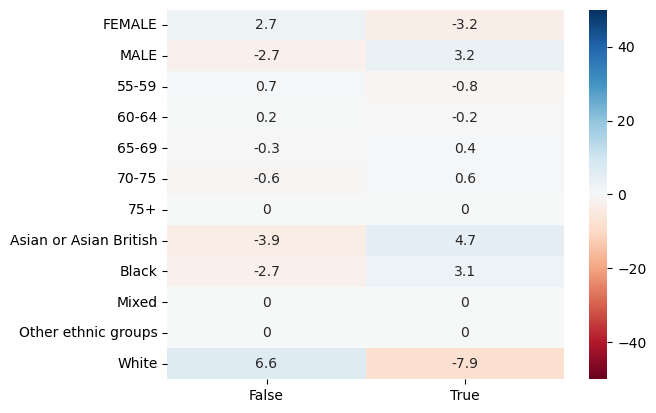

In [4]:
# Show protected characteristics by available sample
xcombined = profile_sample(person_data, table=False, heatmap=False)
display(xcombined)
show_heatmap_of_differences(xcombined)


In [5]:

# Check the protected groups by each other to see whether there is bias

available_data = person_data[person_data.Available]

xperc, xtab = crosstab_with_percentages(
    columns=[
        person_data.participant_age_at_consent_cats
    ],
    rows=[person_data.participant_details_gender],
    table=False,
    heatmap=False
)

display(xtab)

xperc, xtab = crosstab_with_percentages(
    columns=[person_data.lung_health_check_demographics_race_ethnicgroup],
    rows=[person_data.participant_details_gender],
    table=False,
    heatmap=False
)

display(xtab)

xperc, xtab = crosstab_with_percentages(
    columns=[person_data.participant_age_at_consent_cats],
    rows=[person_data.lung_health_check_demographics_race_ethnicgroup],
    table=False,
    heatmap=False
)

display(xtab)

,FEMALE,MALE,Total
55-59,1220 (44.1%),1544 (55.9%),2764
60-64,1349 (41.6%),1891 (58.4%),3240
65-69,1349 (41.0%),1942 (59.0%),3291
70-75,1276 (43.0%),1688 (57.0%),2964
75+,314 (44.9%),385 (55.1%),699
Total,5508 (42.5%),7450 (57.5%),12958


,FEMALE,MALE,Total
Asian or Asian British,72 (8.5%),773 (91.5%),845
Black,221 (38.3%),356 (61.7%),577
Mixed,132 (46.6%),151 (53.4%),283
Other ethnic groups,117 (25.9%),334 (74.1%),451
White,4966 (46.0%),5836 (54.0%),10802
Total,5508 (42.5%),7450 (57.5%),12958


,Asian or Asian British,Black,Mixed,Other ethnic groups,White,Total
55-59,180 (6.5%),163 (5.9%),86 (3.1%),118 (4.3%),2217 (80.2%),2764
60-64,238 (7.3%),150 (4.6%),90 (2.8%),146 (4.5%),2616 (80.7%),3240
65-69,244 (7.4%),152 (4.6%),74 (2.2%),96 (2.9%),2725 (82.8%),3291
70-75,137 (4.6%),89 (3.0%),29 (1.0%),80 (2.7%),2629 (88.7%),2964
75+,46 (6.6%),23 (3.3%),4 (0.6%),11 (1.6%),615 (88.0%),699
Total,845 (6.5%),577 (4.5%),283 (2.2%),451 (3.5%),10802 (83.4%),12958


,Training,Validation,Test,Total
FEMALE,1865 (39.2%),110 (37.0%),361 (40.5%),5508 (42.5%)
MALE,2887 (60.8%),187 (63.0%),530 (59.5%),7450 (57.5%)
55-59,963 (20.3%),63 (21.2%),194 (21.8%),2764 (21.3%)
60-64,1174 (24.7%),98 (33.0%),202 (22.7%),3240 (25.0%)
65-69,1246 (26.2%),58 (19.5%),226 (25.4%),3291 (25.4%)
70-75,1109 (23.3%),61 (20.5%),227 (25.5%),2964 (22.9%)
75+,260 (5.5%),17 (5.7%),42 (4.7%),699 (5.4%)
Asian or Asian British,509 (10.7%),41 (13.8%),116 (13.0%),845 (6.5%)
Black,372 (7.8%),17 (5.7%),65 (7.3%),577 (4.5%)
Mixed,101 (2.1%),7 (2.4%),20 (2.2%),283 (2.2%)


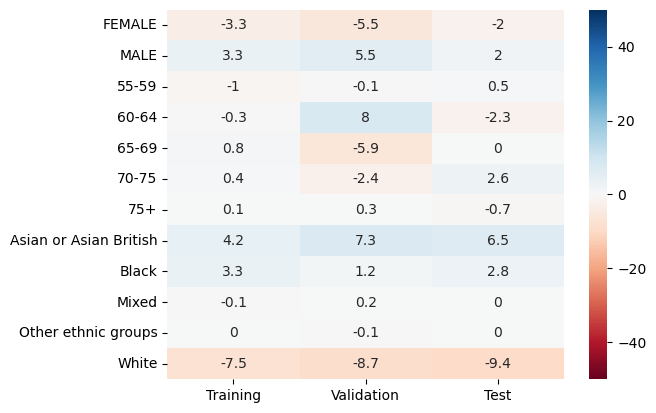

In [6]:

# Historically generated dataset no need to generate here

training_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/partial/training_scans_metadata.csv', low_memory=False).assign(Available=True)
validation_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/partial/validation_scans_metadata.csv', low_memory=False).assign(Available=True)
test_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_scans_metadata.csv', low_memory=False).assign(Available=True)

datasets = {
    'total' : person_data,
    'training' : 
    {
        'partial' : training_scans_metadata
    },
    'validation' : 
    {
        'partial' : validation_scans_metadata
    },
    'test' : 
    {
        'partial' : test_scans_metadata
    }
}

combine_datasets_profiles('partial', datasets)

# Test-Balanced (Ethnicity, Skewed Gender)

When this sample was trained & evaluated on SUMMIT the numbers in the protected groups was so low that it was not possible to get a decent confidence interval to be confident of the results.

Therefore in order to reduce the confidence interval this next experiment will be to increase the Test cases for the protected groups whilst maintaining the best balance possible for the rest of the training.

The following work generates the Trn, Val & Tst datasets along those lines.

,Training,Validation,Test,Total
FEMALE,1961 (38.6%),125 (46.8%),250 (42.1%),5508 (42.5%)
MALE,3118 (61.4%),142 (53.2%),344 (57.9%),7450 (57.5%)
55-59,1033 (20.3%),52 (19.5%),135 (22.7%),2764 (21.3%)
60-64,1267 (24.9%),59 (22.1%),148 (24.9%),3240 (25.0%)
65-69,1294 (25.5%),71 (26.6%),165 (27.8%),3291 (25.4%)
70-75,1213 (23.9%),70 (26.2%),114 (19.2%),2964 (22.9%)
75+,272 (5.4%),15 (5.6%),32 (5.4%),699 (5.4%)
Asian or Asian British,443 (8.7%),25 (9.4%),198 (33.3%),845 (6.5%)
Black,244 (4.8%),12 (4.5%),198 (33.3%),577 (4.5%)
Mixed,119 (2.3%),9 (3.4%),NaN,283 (2.2%)


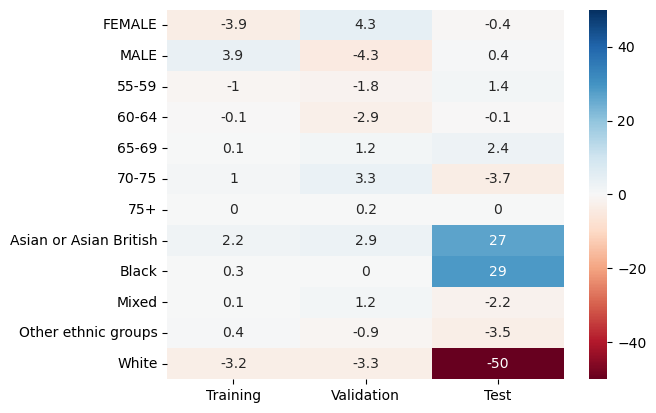

In [7]:


# Historically generated dataset no need to generate here

training_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/training_scans_metadata.csv', low_memory=False).assign(Available=True)
validation_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/validation_scans_metadata.csv', low_memory=False).assign(Available=True)
test_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/test_scans_metadata.csv', low_memory=False).assign(Available=True)

datasets = {
    'total' : person_data,
    'training' : 
    {
        'test_balanced' : training_scans_metadata
    },
    'validation' : 
    {
        'test_balanced' : validation_scans_metadata
    },
    'test' : 
    {
        'test_balanced' : test_scans_metadata
    }
}

combine_datasets_profiles('test_balanced', datasets)

# Male only - Ethnicity

In [8]:
male_only = person_data[
    person_data['Available']&\
    (person_data['participant_details_gender'] == 'MALE')
]


display(male_only['lung_health_check_demographics_race_ethnicgroup'].value_counts())

male_white_ds = male_only[male_only['lung_health_check_demographics_race_ethnicgroup']=='White']
male_asian_ds = male_only[male_only['lung_health_check_demographics_race_ethnicgroup']=='Asian or Asian British']
male_black_ds = male_only[male_only['lung_health_check_demographics_race_ethnicgroup']=='Black']


# Fix the Test dataset as 140 for White, Black and Asian
tst_male_white_ds = male_white_ds.sample(140, random_state=42)
tst_male_asian_ds = male_asian_ds.sample(140, random_state=42)
tst_male_black_ds = male_black_ds.sample(140, random_state=42)

test_ds = pd.concat([
    tst_male_white_ds,
    tst_male_asian_ds,
    tst_male_black_ds
])

total = 5 * 3 * 140
tota_trn_val = 0.8 * total
training_and_validation = male_only.drop(test_ds.index)

proportions = {
    'White'                     :  tota_trn_val * 0.834,
    'Asian or Asian British'    :  tota_trn_val * 0.065,
    'Black'                     :  tota_trn_val * 0.045,
    'Mixed'                     :  tota_trn_val * 0.022,
    'Other ethnic groups'       :  tota_trn_val * 0.034
}

subset = []
for ethnic_group, cnt in proportions.items():
    subset.append(training_and_validation[training_and_validation['lung_health_check_demographics_race_ethnicgroup']==ethnic_group].sample(int(cnt), random_state=42))

training_and_validation = pd.concat(subset)
training_ds = training_and_validation.sample(frac=(15/16), random_state=42)
validation_ds = training_and_validation.drop(training_ds.index)

datasets['training']['male_only']       = training_ds
datasets['validation']['male_only']     = validation_ds
datasets['test']['male_only']           = test_ds


White                     2495
Asian or Asian British     609
Black                      282
Other ethnic groups        149
Mixed                       69
Name: lung_health_check_demographics_race_ethnicgroup, dtype: int64

,Training,Validation,Test,Total
MALE,1573 (100.0%),105 (100.0%),420 (100.0%),7450 (57.5%)
55-59,297 (18.9%),19 (18.1%),92 (21.9%),2764 (21.3%)
60-64,382 (24.3%),27 (25.7%),93 (22.1%),3240 (25.0%)
65-69,420 (26.7%),26 (24.8%),126 (30.0%),3291 (25.4%)
70-75,386 (24.5%),25 (23.8%),87 (20.7%),2964 (22.9%)
75+,88 (5.6%),8 (7.6%),22 (5.2%),699 (5.4%)
Asian or Asian British,98 (6.2%),11 (10.5%),140 (33.3%),845 (6.5%)
Black,71 (4.5%),4 (3.8%),140 (33.3%),577 (4.5%)
Mixed,34 (2.2%),2 (1.9%),NaN,283 (2.2%)
Other ethnic groups,53 (3.4%),4 (3.8%),NaN,451 (3.5%)


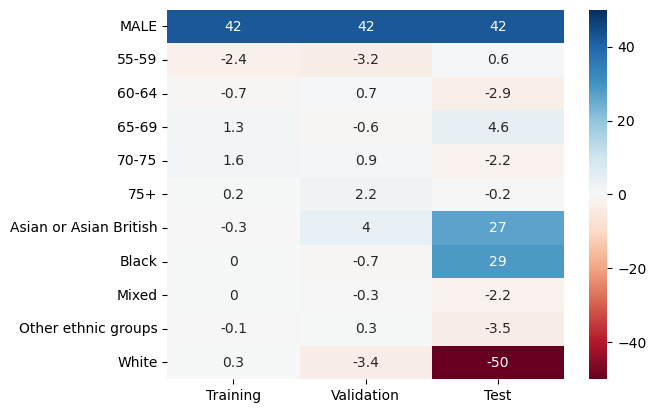

male_only training scans metadata saved
male_only training scans metadata shape: (1573, 319)
male_only training metadata saved
male_only training metadata shape: (2118, 38)
male_only validation scans metadata saved
male_only validation scans metadata shape: (105, 319)
male_only validation metadata saved
male_only validation metadata shape: (121, 38)
male_only test scans metadata saved
male_only test scans metadata shape: (420, 319)
male_only test metadata saved
male_only test metadata shape: (480, 38)
dataset json nodules saved for male_only: 946 training, 420 test
male_only deployed to cluster


In [9]:

combine_datasets_profiles('male_only', datasets)
_ = save_metadata(datasets, 'male_only', nodule_data)

deploy_to_cluster('male_only', use_poxy=False)


## Create Test Dataset of the Female Only Group - Inference Only

This is a test dataset to test performance on the different subsets of Female when trained on Male only

1. Create one small one with balanced test data
2. Create one with everything


,Test,Total
FEMALE,171 (100.0%),5508 (42.5%)
55-59,55 (32.2%),2764 (21.3%)
60-64,39 (22.8%),3240 (25.0%)
65-69,37 (21.6%),3291 (25.4%)
70-75,34 (19.9%),2964 (22.9%)
75+,6 (3.5%),699 (5.4%)
Asian or Asian British,57 (33.3%),845 (6.5%)
Black,57 (33.3%),577 (4.5%)
White,57 (33.3%),10802 (83.4%)
Total,171,12958


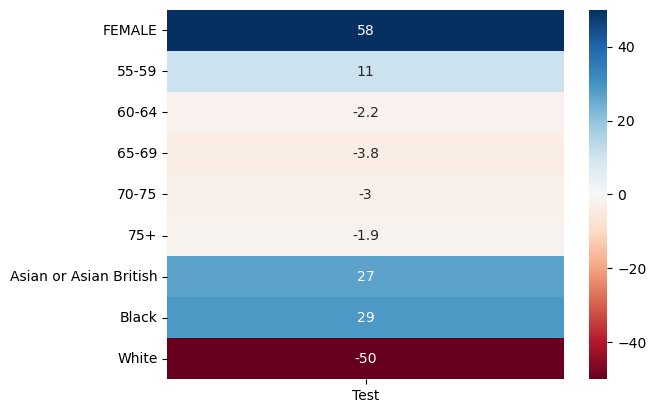

balanced_female_for_inference training scans metadata saved
balanced_female_for_inference training scans metadata shape: (0, 319)
balanced_female_for_inference training metadata saved
balanced_female_for_inference training metadata shape: (0, 38)
balanced_female_for_inference validation scans metadata saved
balanced_female_for_inference validation scans metadata shape: (0, 319)
balanced_female_for_inference validation metadata saved
balanced_female_for_inference validation metadata shape: (0, 38)
balanced_female_for_inference test scans metadata saved
balanced_female_for_inference test scans metadata shape: (171, 319)
balanced_female_for_inference test metadata saved
balanced_female_for_inference test metadata shape: (180, 38)
dataset json nodules saved for balanced_female_for_inference: 0 training, 171 test
balanced_female_for_inference deployed to cluster


ssh: connect to host localhost port 2222: Connection refused
scp: Connection closed
ssh: connect to host localhost port 2222: Connection refused
scp: Connection closed


In [10]:
# Balanced the Test Dataset
female_only = person_data[
    person_data['Available']&\
    (person_data['participant_details_gender'] == 'FEMALE')
]

empty_ds = female_only.drop(female_only.index)

white_ds = female_only[female_only['lung_health_check_demographics_race_ethnicgroup']=='White'].sample(n=57, random_state=42)
black_ds = female_only[female_only['lung_health_check_demographics_race_ethnicgroup']=='Black'].sample(n=57, random_state=42)
asian_ds = female_only[female_only['lung_health_check_demographics_race_ethnicgroup']=='Asian or Asian British'].sample(n=57, random_state=42)

test_ds = pd.concat([white_ds, black_ds, asian_ds]).sample(frac=1, random_state=42)

datasets['training']['balanced_female_for_inference'] = empty_ds
datasets['validation']['balanced_female_for_inference'] = empty_ds
datasets['test']['balanced_female_for_inference'] = test_ds

combine_datasets_profiles('balanced_female_for_inference', datasets)
_ = save_metadata(datasets, 'balanced_female_for_inference', nodule_data)

deploy_to_cluster('balanced_female_for_inference')

,Test,Total
FEMALE,2336 (100.0%),5508 (42.5%)
55-59,510 (21.8%),2764 (21.3%)
60-64,561 (24.0%),3240 (25.0%)
65-69,572 (24.5%),3291 (25.4%)
70-75,565 (24.2%),2964 (22.9%)
75+,128 (5.5%),699 (5.4%)
Asian or Asian British,57 (2.4%),845 (6.5%)
Black,172 (7.4%),577 (4.5%)
Mixed,59 (2.5%),283 (2.2%)
Other ethnic groups,57 (2.4%),451 (3.5%)


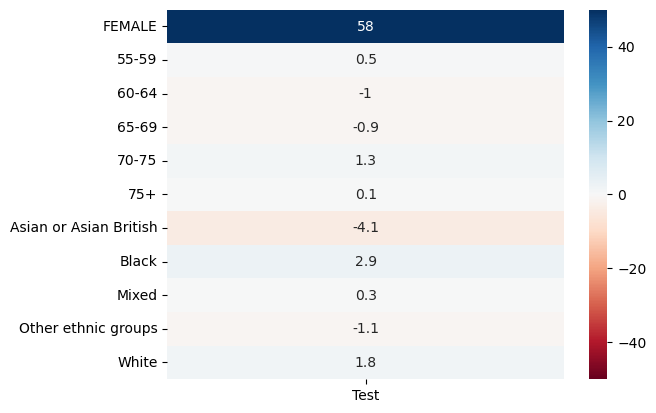

female_for_inference training scans metadata saved
female_for_inference training scans metadata shape: (0, 319)
female_for_inference training metadata saved
female_for_inference training metadata shape: (0, 38)
female_for_inference validation scans metadata saved
female_for_inference validation scans metadata shape: (0, 319)
female_for_inference validation metadata saved
female_for_inference validation metadata shape: (0, 38)
female_for_inference test scans metadata saved
female_for_inference test scans metadata shape: (2336, 319)
female_for_inference test metadata saved
female_for_inference test metadata shape: (2989, 38)
dataset json nodules saved for female_for_inference: 0 training, 2336 test
female_for_inference deployed to cluster


ssh: connect to host localhost port 2222: Connection refused
scp: Connection closed
ssh: connect to host localhost port 2222: Connection refused
scp: Connection closed


In [11]:
female_only = person_data[
    person_data['Available']&\
    (person_data['participant_details_gender'] == 'FEMALE')
]

datasets['training']['female_for_inference'] = empty_ds
datasets['validation']['female_for_inference'] = empty_ds
datasets['test']['female_for_inference'] = female_only.sample(frac=1, random_state=42)

combine_datasets_profiles('female_for_inference', datasets)
_ = save_metadata(datasets, 'female_for_inference', nodule_data)

deploy_to_cluster('female_for_inference')

# White only - Gender investigations

Total white only scans: 4486


,Training,Validation,Test,Total
FEMALE,1494 (44.4%),98 (43.8%),399 (44.4%),5508 (42.5%)
MALE,1870 (55.6%),126 (56.2%),499 (55.6%),7450 (57.5%)
55-59,625 (18.6%),43 (19.2%),178 (19.8%),2764 (21.3%)
60-64,795 (23.6%),49 (21.9%),219 (24.4%),3240 (25.0%)
65-69,869 (25.8%),68 (30.4%),208 (23.2%),3291 (25.4%)
70-75,881 (26.2%),54 (24.1%),240 (26.7%),2964 (22.9%)
75+,194 (5.8%),10 (4.5%),53 (5.9%),699 (5.4%)
White,3364 (100.0%),224 (100.0%),898 (100.0%),10802 (83.4%)
Total,3364,224,898,12958


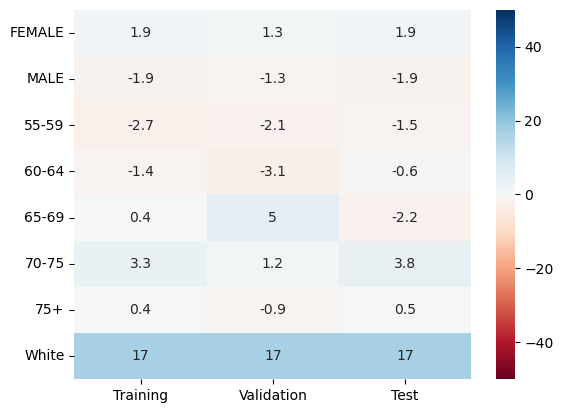

white_only training scans metadata saved
white_only training scans metadata shape: (3364, 319)
white_only training metadata saved
white_only training metadata shape: (4613, 38)
white_only validation scans metadata saved
white_only validation scans metadata shape: (224, 319)
white_only validation metadata saved
white_only validation metadata shape: (300, 38)
white_only test scans metadata saved
white_only test scans metadata shape: (898, 319)
white_only test metadata saved
white_only test metadata shape: (1218, 38)
dataset json nodules saved for white_only: 2107 training, 898 test
white_only deployed to cluster


ssh: connect to host localhost port 2222: Connection refused
scp: Connection closed
ssh: connect to host localhost port 2222: Connection refused
scp: Connection closed


In [15]:


white_only = person_data[
    person_data['Available']&\
    (person_data['lung_health_check_demographics_race_ethnicgroup'] == 'White')
]

total = white_only.shape[0]

print(f'Total white only scans: {total}')

# Get the counts for each dataset
trn_cnt = int(total * 0.75)
val_cnt = int(total * 0.05)
tst_cnt = int(total * 0.20)

datasets['training']['white_only'] = white_only.loc[white_only.index[:trn_cnt],:]
datasets['validation']['white_only'] = white_only.loc[white_only.index[trn_cnt:trn_cnt+val_cnt],:]
datasets['test']['white_only'] = white_only.loc[white_only.index[trn_cnt+val_cnt:],:]


test_ds = white_only.loc[white_only.index[trn_cnt+val_cnt:],:]
test_ds_male = test_ds[test_ds['participant_details_gender']=='MALE'].sample(399, random_state=42)
test_ds_female = test_ds[test_ds['participant_details_gender']=='FEMALE']

datasets['training']['balanced_white_only'] = empty_ds
datasets['validation']['balanced_white_only'] = empty_ds
datasets['test']['balanced_white_only'] = pd.concat([test_ds_male, test_ds_female]).sample(frac=1, random_state=42)


combine_datasets_profiles('white_only', datasets)
_ = save_metadata(datasets, 'white_only', nodule_data)

deploy_to_cluster('white_only')


,Test,Total
FEMALE,399 (50.0%),5508 (42.5%)
MALE,399 (50.0%),7450 (57.5%)
55-59,157 (19.7%),2764 (21.3%)
60-64,198 (24.8%),3240 (25.0%)
65-69,179 (22.4%),3291 (25.4%)
70-75,212 (26.6%),2964 (22.9%)
75+,52 (6.5%),699 (5.4%)
White,798 (100.0%),10802 (83.4%)
Total,798,12958


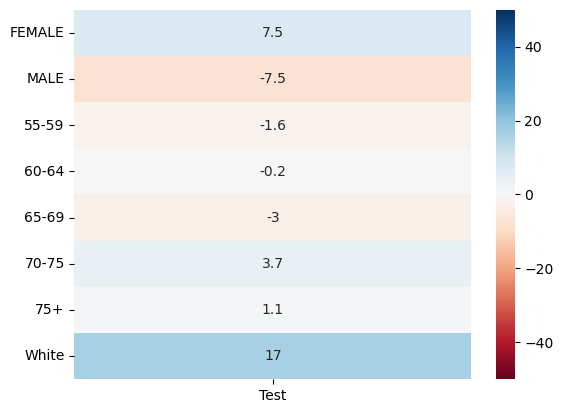

balanced_white_only training scans metadata saved
balanced_white_only training scans metadata shape: (0, 319)
balanced_white_only training metadata saved
balanced_white_only training metadata shape: (0, 38)
balanced_white_only validation scans metadata saved
balanced_white_only validation scans metadata shape: (0, 319)
balanced_white_only validation metadata saved
balanced_white_only validation metadata shape: (0, 38)
balanced_white_only test scans metadata saved
balanced_white_only test scans metadata shape: (798, 319)
balanced_white_only test metadata saved
balanced_white_only test metadata shape: (1105, 38)
dataset json nodules saved for balanced_white_only: 0 training, 798 test
balanced_white_only deployed to cluster


In [17]:
combine_datasets_profiles('balanced_white_only', datasets)
_ = save_metadata(datasets, 'balanced_white_only', nodule_data)
deploy_to_cluster('balanced_white_only')


### Create a dataset for Asian or Asian British and Black participants for inference only

,Test,Total
FEMALE,229 (20.4%),5508 (42.5%)
MALE,891 (79.6%),7450 (57.5%)
55-59,277 (24.7%),2764 (21.3%)
60-64,297 (26.5%),3240 (25.0%)
65-69,309 (27.6%),3291 (25.4%)
70-75,179 (16.0%),2964 (22.9%)
75+,58 (5.2%),699 (5.4%)
Asian or Asian British,666 (59.5%),845 (6.5%)
Black,454 (40.5%),577 (4.5%)
Total,1120,12958


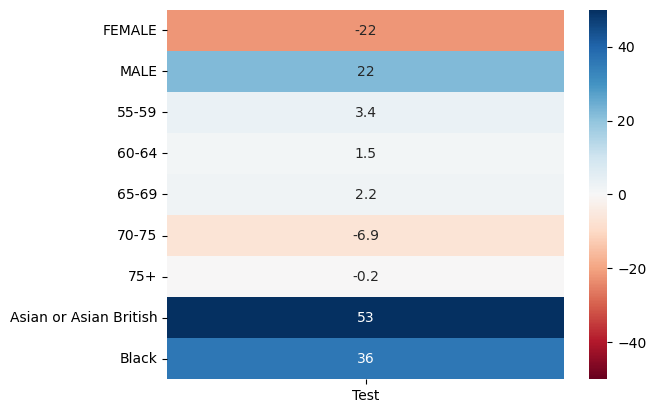

non_white_for_inference training scans metadata saved
non_white_for_inference training scans metadata shape: (0, 319)
non_white_for_inference training metadata saved
non_white_for_inference training metadata shape: (0, 38)
non_white_for_inference validation scans metadata saved
non_white_for_inference validation scans metadata shape: (0, 319)
non_white_for_inference validation metadata saved
non_white_for_inference validation metadata shape: (0, 38)
non_white_for_inference test scans metadata saved
non_white_for_inference test scans metadata shape: (1120, 319)
non_white_for_inference test metadata saved
non_white_for_inference test metadata shape: (1131, 38)
dataset json nodules saved for non_white_for_inference: 0 training, 1120 test
non_white_for_inference deployed to cluster


ssh: connect to host localhost port 2222: Connection refused
scp: Connection closed
ssh: connect to host localhost port 2222: Connection refused
scp: Connection closed


In [13]:
# Balanced the Test Dataset
asian_and_black = person_data[
    person_data['Available']&\
    (person_data['lung_health_check_demographics_race_ethnicgroup'].isin(['Asian or Asian British', 'Black']))
]

empty_ds = asian_and_black.drop(asian_and_black.index)

test_ds = asian_and_black

datasets['training']['non_white_for_inference'] = empty_ds
datasets['validation']['non_white_for_inference'] = empty_ds
datasets['test']['non_white_for_inference'] = test_ds

combine_datasets_profiles('non_white_for_inference', datasets)
_ = save_metadata(datasets, 'non_white_for_inference', nodule_data)

deploy_to_cluster('non_white_for_inference')